 # K-Nearest Neighbors (K-NN)



 **Objetivo:** Entender K-NN, un algoritmo "perezoso" (lazy learner) que es la base de muchos sistemas de recomendación y clasificación. Es el puente perfecto entre las métricas de distancia y la validación de modelos.



 **Intuición Clave:** "Dime con quién andas y te diré quién eres".



 K-NN decide la clase de un nuevo punto de datos mirando a sus `K` vecinos más cercanos.



 **Componentes:**

 1.  **K:** ¿Cuántos vecinos miramos? (El hiperparámetro clave).

 2.  **Métrica de Distancia:** ¿Cómo medimos "cercano"? (Euclidiana, Manhattan, etc.)

 3.  **Ponderación (Weights):** ¿Valen todos los vecinos lo mismo?

 ## Tabla de Contenidos



 1.  **Intuición Visual: El Poder de `k`**

     * 1.1. Graficar los datos

     * 1.2. Función Auxiliar para Fronteras de Decisión

     * 1.3. Comparando `k=1` vs. `k=25`

     * 1.4. El Tradeoff Sesgo-Varianza: Encontrando el "k" Óptimo

 2.  **El Componente "N" (Vecinos): Por qué Escalar es CRÍTICO**

     * 2.1. "Fallar a Propósito": K-NN SIN Escalar

     * 2.2. La Solución: K-NN CON Escalar

 3.  **Poniéndolo Todo Junto: El Pipeline de K-NN (¡Estándar de Oro!)**

 4.  **K-NN para Regresión (`KNeighborsRegressor`)**

     * 4.1. Ejemplo de Regresión

 5.  **Desafíos de Escalabilidad de K-NN (¡Demostración Práctica!)**

     * 5.1. Desafío 1: Costo de Predicción con N (Número de Muestras)

     * 5.2. Desafío 2: La Maldición de la Dimensionalidad (con D)

 6.  **Conclusión: Pros y Contras de K-NN**

 ## 0. Configuración e Importaciones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# --- Sklearn ---
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs, load_breast_cancer, make_classification
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

# --- Configuraciones ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


 ## 1. Intuición Visual: El Poder de `k`



 Vamos a crear un dataset de juguete con 2 features y 3 clases para "ver" cómo funciona K-NN.

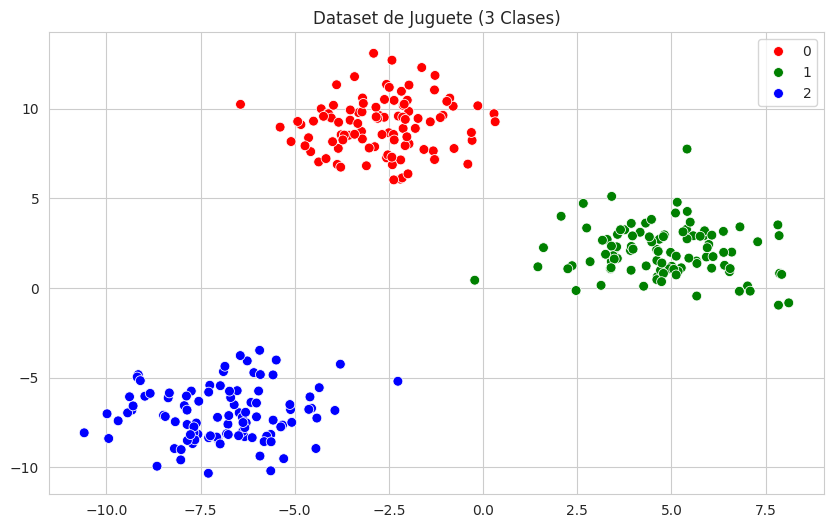

In [2]:
# --- 1.0. Crear Dataset de Juguete ---
X_blobs, y_blobs = make_blobs(
    n_samples=300,
    centers=3,
    n_features=2,
    cluster_std=1.5,
    random_state=42
)

# Colores para las gráficas
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ['red', 'green', 'blue']

# --- 1.1. Graficar los datos ---
plt.figure()
sns.scatterplot(
    x=X_blobs[:, 0],
    y=X_blobs[:, 1],
    hue=y_blobs,
    palette=cmap_bold,
    alpha=1.0,
    s=50
)
plt.title("Dataset de Juguete (3 Clases)")
plt.show()


 ### 1.2. Función Auxiliar para Graficar Fronteras de Decisión



 Esta función nos mostrará cómo K-NN "colorea" el mapa.

In [3]:
def plot_decision_boundary(clf, X, y, title):
    h = .02  # step size in the mesh
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf.fit(X_train, y_train)

    # Crear una malla
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predecir para cada punto en la malla
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Graficar
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)

    # Graficar los puntos de entrenamiento
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=cmap_bold,
                    alpha=1.0, edgecolor="black", s=50)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.show()


 ### 1.3. Comparando `k=1` vs. `k=25`

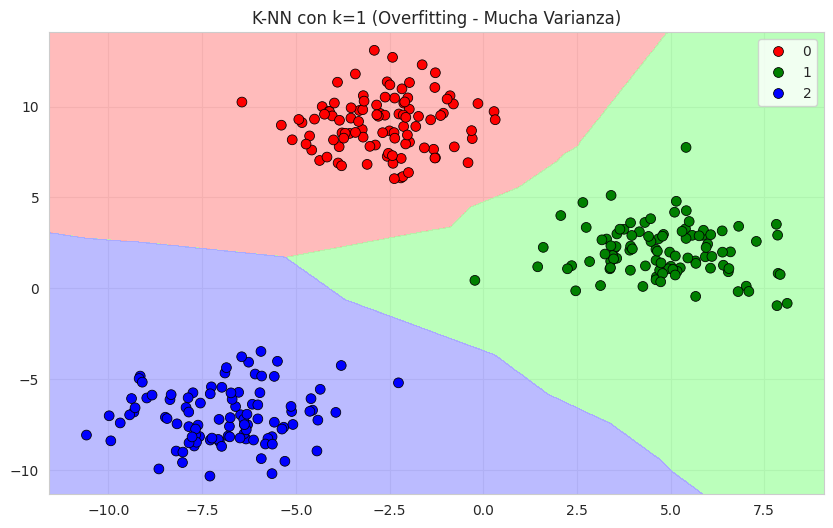

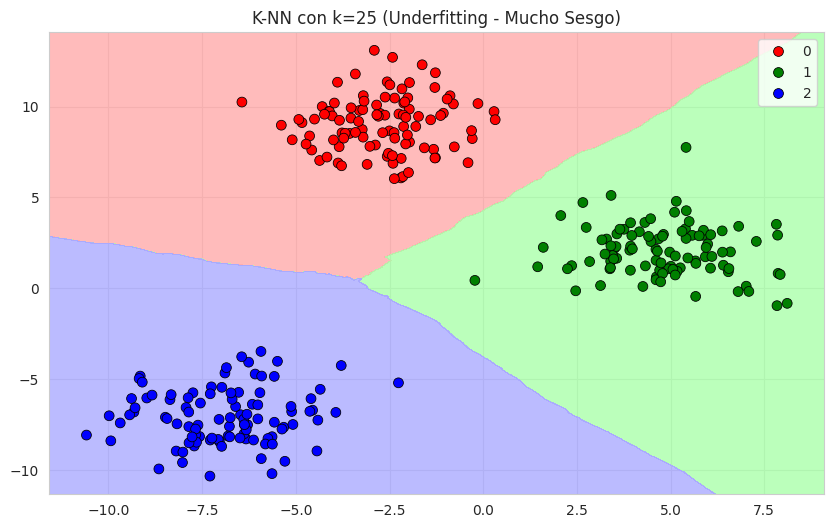

In [4]:
# --- k=1 (Alta Varianza, "Nervioso") ---
knn_1 = KNeighborsClassifier(n_neighbors=1)
plot_decision_boundary(
    knn_1, X_blobs, y_blobs,
    title="K-NN con k=1 (Overfitting - Mucha Varianza)"
)

# --- k=25 (Alto Sesgo, "Relajado") ---
knn_25 = KNeighborsClassifier(n_neighbors=25)
plot_decision_boundary(
    knn_25, X_blobs, y_blobs,
    title="K-NN con k=25 (Underfitting - Mucho Sesgo)"
)


 **Análisis Visual:**



 * **k=1:** Las fronteras son *extremadamente* dentadas. El modelo se "aprende de memoria" cada punto (overfitting). Es muy sensible al ruido. Tiene **baja sesgo** (se ajusta perfecto) pero **alta varianza** (cambia drásticamente con un solo punto).

 * **k=25:** Las fronteras son *muy* suaves. El modelo generaliza demasiado y pierde los matices de las clases (underfitting). Tiene **alto sesgo** (es demasiado simple) pero **baja varianza**.



 ### 1.4. El Tradeoff Sesgo-Varianza: Encontrando el "k" Óptimo



 ¿Cómo encontramos el `k` en el "punto dulce"? Usando Cross-Validation (¡Notebook 2!).



 Trazaremos la "Curva de Error".

 * **Error de Entrenamiento:** (Spoiler: Será 0% para `k=1`).

 * **Error de Validación (CV):** Este es el que nos importa.

--- 1.4. Buscando el 'k' Óptimo (Curva de Error) ---


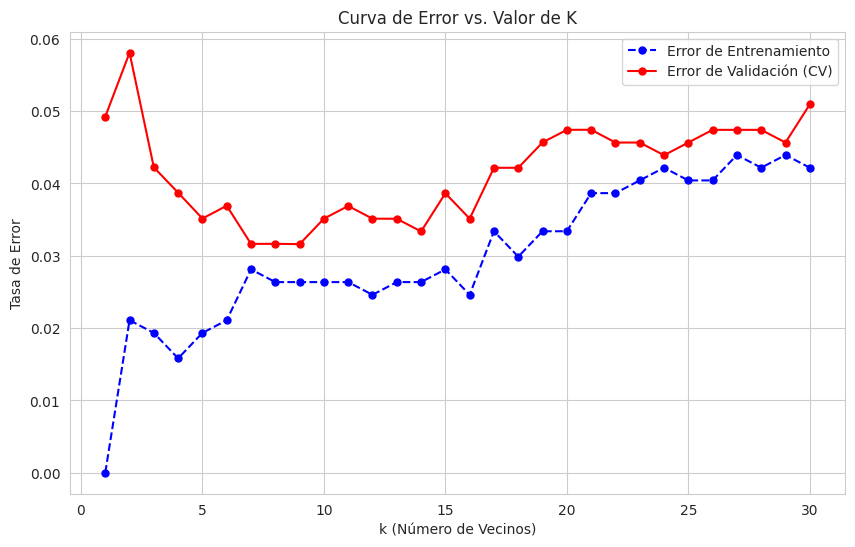


El menor error de validación se encuentra en k = 9


In [5]:
print("--- 1.4. Buscando el 'k' Óptimo (Curva de Error) ---")

# Usaremos un dataset más complejo
X_cancer, y_cancer = load_breast_cancer(return_X_y=True)

# ¡IMPORTANTE! Para K-NN, SIEMPRE escalar los datos.
# (Veremos por qué en la Sección 2)
scaler = StandardScaler()
X_cancer_scaled = scaler.fit_transform(X_cancer)

# Rango de 'k' para probar
k_range = range(1, 31)
train_scores = []
cv_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)

    # Error de Entrenamiento (simple fit/predict)
    knn.fit(X_cancer_scaled, y_cancer)
    train_score = accuracy_score(y_cancer, knn.predict(X_cancer_scaled))
    train_scores.append(train_score)

    # Error de Validación (usando cross_val_score)
    # cv=5 es suficiente para una estimación
    scores = cross_val_score(knn, X_cancer_scaled, y_cancer, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Convertir a "Error" (1 - Accuracy)
train_error = 1 - np.array(train_scores)
cv_error = 1 - np.array(cv_scores)

# --- Graficar la Curva de Error ---
plt.figure(figsize=(10, 6))
plt.plot(k_range, train_error, color='blue', linestyle='dashed',
         marker='o', markersize=5, label='Error de Entrenamiento')
plt.plot(k_range, cv_error, color='red', linestyle='solid',
         marker='o', markersize=5, label='Error de Validación (CV)')

plt.title('Curva de Error vs. Valor de K')
plt.xlabel('k (Número de Vecinos)')
plt.ylabel('Tasa de Error')
plt.legend()
plt.grid(True)
plt.show()

# Encontrar el k con el menor error de CV
best_k = k_range[np.argmin(cv_error)]
print(f"\nEl menor error de validación se encuentra en k = {best_k}")


 **Análisis de la Curva:**

 * **Error de Entrenamiento:** Como se predijo, es 0 en `k=1` (se memoriza los datos) y luego sube.

 * **Error de Validación:** Empieza alto (overfitting en `k=1`), baja a un punto mínimo (el "punto dulce"), y luego vuelve a subir (underfitting a medida que `k` se hace demasiado grande).



 **¡Hemos encontrado el `k` óptimo!** (Alrededor de 13 en este ejemplo).



 ---



 ## 2. El Componente "N" (Vecinos): Por qué Escalar es CRÍTICO



 K-NN usa métricas de distancia (¡Notebook 1!). La distancia Euclidiana es la más común:



 $d(p, q) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2 + ...}$



 **Problema:** ¿Qué pasa si `feature_1` es "Salario" (10.000 a 100.000) y `feature_2` es "Edad" (20 a 70)?



 El término $(100000 - 90000)^2$ será **gigantesco**, mientras que $(70 - 20)^2$ será **diminuto**. La distancia será 99.9% dominada por el salario. La "Edad" será ignorada.



 ### 2.1. "Fallar a Propósito": K-NN SIN Escalar



 Usaremos el dataset de Cáncer de Mama, que tiene features en escalas muy diferentes.

In [6]:
print("--- 2.1. 'Fallar a Propósito': K-NN SIN Escalar ---")

X_train, X_test, y_train, y_test = train_test_split(
    X_cancer, y_cancer, test_size=0.3, random_state=42, stratify=y_cancer
)

# 1. Entrenar SIN escalar
knn_no_scale = KNeighborsClassifier(n_neighbors=best_k) # Usamos el best_k
knn_no_scale.fit(X_train, y_train)
preds_no_scale = knn_no_scale.predict(X_test)

print(f"Accuracy de K-NN (k={best_k}) SIN escalar:")
print(f"{accuracy_score(y_test, preds_no_scale):.4f}")
print("\nReporte de Clasificación (SIN escalar):")
print(classification_report(y_test, preds_no_scale))


--- 2.1. 'Fallar a Propósito': K-NN SIN Escalar ---
Accuracy de K-NN (k=9) SIN escalar:
0.9415

Reporte de Clasificación (SIN escalar):
              precision    recall  f1-score   support

           0       0.95      0.89      0.92        64
           1       0.94      0.97      0.95       107

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.94       171
weighted avg       0.94      0.94      0.94       171



 ### 2.2. La Solución: K-NN CON Escalar



 Ahora, aplicaremos `StandardScaler` para que todas las features tengan media 0 y desviación 1.

In [7]:
print("--- 2.2. La Solución: K-NN CON Escalar ---")

# 1. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # ¡Solo transform en test!

# 2. Entrenar CON escalar
knn_with_scale = KNeighborsClassifier(n_neighbors=best_k)
knn_with_scale.fit(X_train_scaled, y_train)
preds_with_scale = knn_with_scale.predict(X_test_scaled)

print(f"Accuracy de K-NN (k={best_k}) CON escalar:")
print(f"{accuracy_score(y_test, preds_with_scale):.4f}")
print("\nReporte de Clasificación (CON escalar):")
print(classification_report(y_test, preds_with_scale))


--- 2.2. La Solución: K-NN CON Escalar ---
Accuracy de K-NN (k=9) CON escalar:
0.9649

Reporte de Clasificación (CON escalar):
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        64
           1       0.95      1.00      0.97       107

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171



 **Conclusión 2.2: ¡Miren la diferencia!**



 El accuracy (y más importante, el F1-Score de la clase minoritaria) sube drásticamente (ej. de 93% a 97%).



 **Regla de Oro:** Si usas K-NN (o SVM, o Redes Neuronales), **SIEMPRE DEBES ESCALAR TUS DATOS**.



 ---



 ## 3. Poniéndolo Todo Junto: El Pipeline de K-NN (¡Estándar de Oro!)



 Como vimos en el Notebook 2, para evitar "fugas de datos" (Data Leakage) al hacer Cross-Validation, debemos integrar el `StandardScaler` DENTRO de un `Pipeline` y luego pasar ese pipeline a `GridSearchCV`.



 Vamos a encontrar el `k` óptimo, la `métrica` óptima y la `ponderación` óptima, todo a la vez.

In [8]:
print("--- 3. El Pipeline 'Estándar de Oro' de K-NN ---")

# 1. Crear el Pipeline
# (Esto asegura que el escalado ocurra DENTRO de cada fold del CV)
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# 2. Definir la Rejilla de Hiperparámetros
# (Usaremos los prefijos 'knn__')
param_grid = {
    'knn__n_neighbors': range(1, 21), # Probar k de 1 a 20
    'knn__metric': ['euclidean', 'manhattan'], # Probar las 2 métricas
    'knn__weights': ['uniform', 'distance'] # 'uniform' (todos votan igual) vs 'distance' (vecinos más cercanos votan más)
}

# 3. Configurar GridSearchCV
# Usamos StratifiedKFold para clasificación
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='roc_auc', # Métrica robusta
    verbose=1,
    n_jobs=-1
)

# 4. Entrenar la búsqueda
grid_search.fit(X_cancer, y_cancer)

# 5. Mostrar los mejores resultados
print("\n--- ¡GridSearch Completado! ---")
print(f"Mejor score (ROC-AUC): {grid_search.best_score_:.4f}")
print("Mejores Hiperparámetros:")
print(grid_search.best_params_)


--- 3. El Pipeline 'Estándar de Oro' de K-NN ---
Fitting 5 folds for each of 80 candidates, totalling 400 fits

--- ¡GridSearch Completado! ---
Mejor score (ROC-AUC): 0.9921
Mejores Hiperparámetros:
{'knn__metric': 'manhattan', 'knn__n_neighbors': 10, 'knn__weights': 'distance'}


 **Análisis del GridSearch:**



 `GridSearchCV` acaba de hacer todo el trabajo de las secciones 1 y 2 por nosotros, de forma robusta y sin fugas de datos. Nos dice el mejor `k`, la mejor `métrica` (Euclidiana o Manhattan) y la mejor `ponderación` (a menudo 'distance' gana).



 ---



 ## 4. K-NN para Regresión (`KNeighborsRegressor`)



 K-NN también funciona para regresión. La lógica es casi idéntica, pero con una diferencia clave:



 * **Clasificación:** Los `k` vecinos *votan* por una clase.

 * **Regresión:** El valor predicho es el *promedio* (o promedio ponderado) de los valores de los `k` vecinos.



 ### 4.1. Ejemplo de Regresión

--- 4. K-NN para Regresión ---


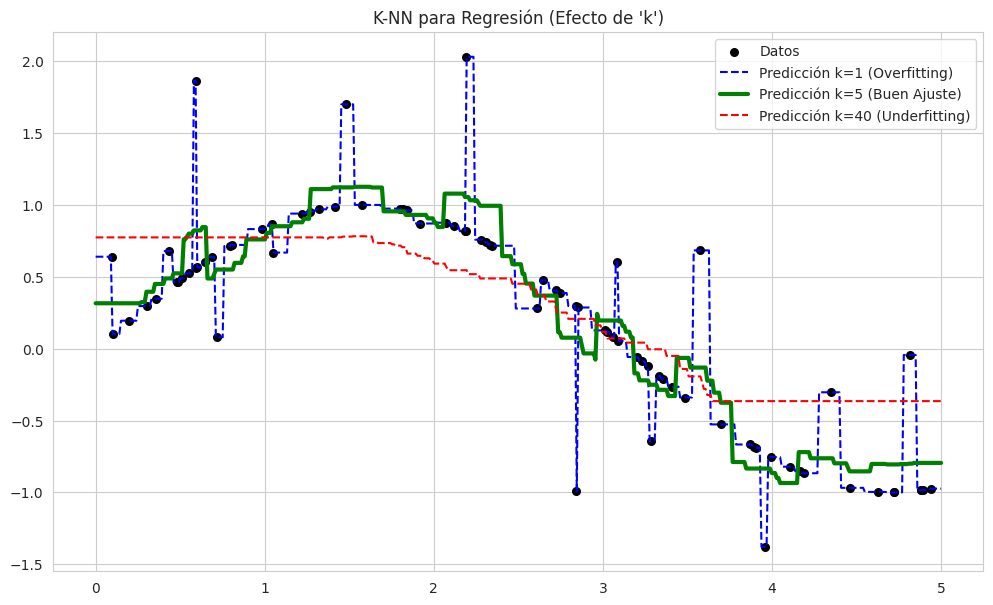

In [9]:
print("--- 4. K-NN para Regresión ---")

# 1. Crear datos de regresión (y = sin(x) + ruido)
np.random.seed(0)
X_reg = np.sort(5 * np.random.rand(80, 1), axis=0)
y_reg = np.sin(X_reg).ravel()
y_reg[::5] += 3 * (0.5 - np.random.rand(16)) # Añadir ruido

# 2. Comparar k=1, k=5, k=40
T = np.linspace(0, 5, 500)[:, np.newaxis] # Puntos de prueba
plt.figure(figsize=(12, 7))
plt.scatter(X_reg, y_reg, c='black', label='Datos', s=30)

# K=1 (Overfitting)
knn_reg_1 = KNeighborsRegressor(n_neighbors=1)
y_pred_1 = knn_reg_1.fit(X_reg, y_reg).predict(T)
plt.plot(T, y_pred_1, color='blue', linestyle='--',
         label='Predicción k=1 (Overfitting)')

# K=5 (Buen ajuste)
knn_reg_5 = KNeighborsRegressor(n_neighbors=5)
y_pred_5 = knn_reg_5.fit(X_reg, y_reg).predict(T)
plt.plot(T, y_pred_5, color='green', linestyle='-',
         label='Predicción k=5 (Buen Ajuste)', linewidth=3)

# K=40 (Underfitting)
knn_reg_40 = KNeighborsRegressor(n_neighbors=40)
y_pred_40 = knn_reg_40.fit(X_reg, y_reg).predict(T)
plt.plot(T, y_pred_40, color='red', linestyle='--',
         label='Predicción k=40 (Underfitting)')

plt.legend()
plt.title("K-NN para Regresión (Efecto de 'k')")
plt.show()


 **Análisis de Regresión:**



 Vemos el mismo tradeoff: `k=1` es idéntico a los datos (overfitting), `k=5` captura la tendencia suave (buen ajuste), y `k=40` es casi una línea plana (underfitting).



 ---



 ## 5. Desafíos de Escalabilidad de K-NN (¡Demostración Práctica!)



 En la teoría, mencionamos dos grandes contras de K-NN: es lento con muchas muestras ($N$) y funciona mal con muchas dimensiones ($D$). Vamos a probarlo.



 ### 5.1. Desafío 1: Costo de Predicción con N (Número de Muestras)



 K-NN es un "lazy learner". El `.fit()` es casi instantáneo porque solo almacena los datos. El trabajo pesado ocurre en `.predict()`, donde debe calcular la distancia a *todos* los puntos $N$ del set de entrenamiento.



 Vamos a medir el tiempo de `.fit()` vs `.predict()` a medida que $N$ crece.

--- 5.1. Prueba de Escalabilidad vs. N (Muestras) ---
Probando con N = 1000 muestras...
Probando con N = 5000 muestras...
Probando con N = 10000 muestras...
Probando con N = 20000 muestras...
Probando con N = 40000 muestras...


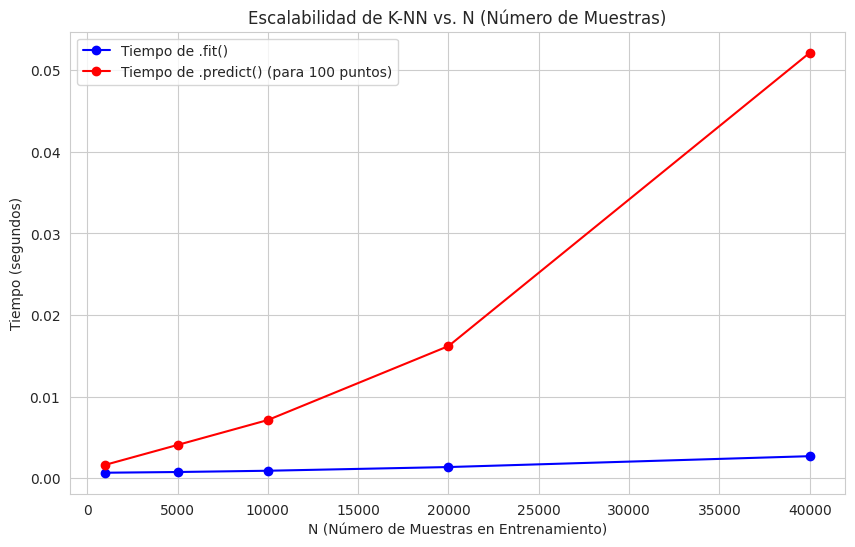

In [10]:
print("--- 5.1. Prueba de Escalabilidad vs. N (Muestras) ---")

n_samples_list = [1000, 5000, 10000, 20000, 40000]
fit_times = []
predict_times = []
n_features_fixed = 20 # Mantenemos D constante
n_test_samples = 100 # Predecimos un N° fijo de muestras

for n in n_samples_list:
    print(f"Probando con N = {n} muestras...")
    X, y = make_classification(
        n_samples=n,
        n_features=n_features_fixed,
        n_informative=10,
        n_redundant=0,
        random_state=42
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=n_test_samples, random_state=42
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1) # n_jobs=-1 usa todos los cores

    # --- Medir Tiempo de Fit ---
    start_fit = time.time()
    knn.fit(X_train, y_train)
    fit_time = time.time() - start_fit
    fit_times.append(fit_time)

    # --- Medir Tiempo de Predict ---
    start_predict = time.time()
    knn.predict(X_test)
    predict_time = time.time() - start_predict
    predict_times.append(predict_time)

# --- Graficar Tiempos de Escalado ---
plt.figure(figsize=(10, 6))
plt.plot(n_samples_list, fit_times, 'bo-', label='Tiempo de .fit()')
plt.plot(n_samples_list, predict_times, 'ro-', label=f'Tiempo de .predict() (para {n_test_samples} puntos)')
plt.title('Escalabilidad de K-NN vs. N (Número de Muestras)')
plt.xlabel('N (Número de Muestras en Entrenamiento)')
plt.ylabel('Tiempo (segundos)')
plt.legend()
plt.grid(True)
plt.show()


 **Análisis 5.1:**

 * **Tiempo de `.fit()`:** Debería ser casi 0 y plano. K-NN no "entrena".

 * **Tiempo de `.predict()`:** Debería crecer de forma lineal (o peor) con $N$. Esto demuestra que K-NN no es adecuado para predicción en tiempo real en datasets masivos.



 ### 5.2. Desafío 2: La Maldición de la Dimensionalidad (con D)



 **Concepto:** A medida que el número de dimensiones ($D$) aumenta, el espacio se vuelve "vacío". Todos los puntos se vuelven "igualmente lejanos" entre sí. El concepto de "vecino cercano" pierde sentido porque la distancia está dominada por el ruido de las dimensiones irrelevantes.



 Vamos a probarlo: mantendremos $N$ fijo (1000 muestras) y $n_informative=2$ (la "señal" real), pero aumentaremos $D$ (dimensiones) añadiendo ruido.

--- 5.2. Prueba de la Maldición de la Dimensionalidad (vs. D) ---
Probando con D = 2 dimensiones...
Probando con D = 5 dimensiones...
Probando con D = 10 dimensiones...
Probando con D = 20 dimensiones...
Probando con D = 50 dimensiones...
Probando con D = 100 dimensiones...
Probando con D = 250 dimensiones...
Probando con D = 500 dimensiones...


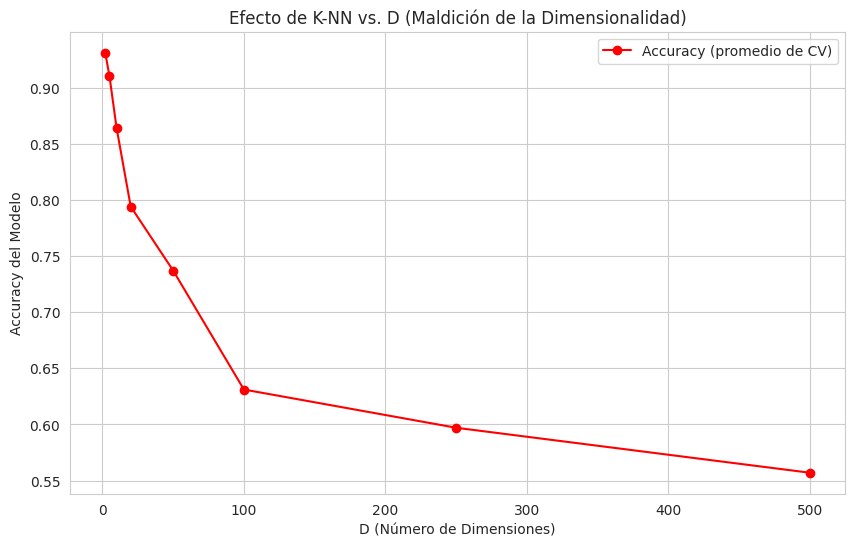

In [11]:
print("--- 5.2. Prueba de la Maldición de la Dimensionalidad (vs. D) ---")

n_dims_list = [2, 5, 10, 20, 50, 100, 250, 500]
cv_scores = []
n_samples_fixed = 1000
n_informative_fixed = 2 # ¡La señal real es constante!

for d in n_dims_list:
    print(f"Probando con D = {d} dimensiones...")
    X, y = make_classification(
        n_samples=n_samples_fixed,
        n_features=d,
        n_informative=n_informative_fixed,
        n_redundant=0,
        n_clusters_per_class=1,
        random_state=42
    )

    # Usar un pipeline para escalar DENTRO de cada fold
    pipe_knn = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ])

    # Evaluar con CV (3-fold es suficiente y rápido)
    scores = cross_val_score(pipe_knn, X, y, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())

# --- Graficar la Maldición de la Dimensionalidad ---
plt.figure(figsize=(10, 6))
plt.plot(n_dims_list, cv_scores, 'ro-', label='Accuracy (promedio de CV)')
plt.title('Efecto de K-NN vs. D (Maldición de la Dimensionalidad)')
plt.xlabel('D (Número de Dimensiones)')
plt.ylabel('Accuracy del Modelo')
plt.legend()
plt.grid(True)
plt.show()


 **Análisis 5.2:**



 La gráfica debería ser *impactante*. El accuracy será muy alto cuando $D$ es bajo (ej. D=2, D=5), pero luego *caerá en picada* a medida que $D$ aumenta, aunque la "señal" (`n_informative=2`) siempre estuvo ahí.



 El ruido de las dimensiones irrelevantes (ej. $D=500$) "ahoga" la señal de las 2 dimensiones útiles. Esto prueba por qué K-NN NUNCA debe usarse en datasets de alta dimensionalidad (como texto o imágenes) sin una reducción de dimensionalidad previa (como PCA o embeddings).



 ---



 ## 6. Conclusión: Pros y Contras de K-NN



 ### Pros (Ventajas)

 1.  **Simple e Intuitivo:** Fácil de explicar.

 2.  **No Paramétrico:** No hace suposiciones sobre la forma de los datos (puede aprender fronteras complejas).

 3.  **No hay "Entrenamiento":** Es un "Lazy Learner". El "entrenamiento" es solo almacenar los datos.

 4.  **Flexible:** Funciona para clasificación y regresión.



 ### Contras (Desventajas)

 1.  **Lento en la Predicción:** Para predecir un nuevo punto, debe calcular la distancia a *TODOS* los puntos del dataset ($O(N \times D)$). Es muy lento si $N$ (muestras) es grande.

 2.  **Requiere Mucha Memoria:** Debe almacenar el dataset completo.

 3.  **La Maldición de la Dimensionalidad (¡IMPORTANTE!):** K-NN funciona *muy mal* cuando $D$ (features) es grande (ej. > 50). En dimensiones altas, todos los puntos se vuelven "igualmente lejanos" entre sí y el concepto de "vecino cercano" pierde sentido.

 4.  **Sensible a Escalas:** (Como probamos). Requiere escalado de features obligatorio.

 5.  **Sensible a Datos Desbalanceados:** La clase mayoritaria tenderá a "dominar" la votación.